# M5 Forecasting Accuracy Research

This is a continuation of my work on analyzing the sales data of Walmart's TX_1 store (Version 1 found here:https://www.kaggle.com/jimmyliuu/m5-forecast-accuracy-research-version-1). This week, I add a couple exogenous variables into my SARIMA model in hopes of improving forecast accuracy. I chose to force weekly seasonality and event_name_1 into the model. 

I followed Jason Brownlee's "How to Decompose Time Series Data into Trend and Seasonality" to build the SARIMAX model with forced weekly seasonality (found here:https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

I followed Oscar Arzamendia's "Time Series Forecasting - A Getting Started Guide" as a guide to feature engineering. I used one-hot-encoding on event_name_1 to feed it into the SARIMAX model (found here:https://towardsdatascience.com/time-series-forecasting-a-getting-started-guide-c435f9fa2216#:~:text=An%20exogenous%20variable%20is%20one,without%20being%20affected%20by%20it.)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv


# Load in relevant datasets

In [2]:
CalendarDF=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv", header=0)
SalesDF=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv", header=0) #June 1st Dataset

In [3]:
import os, psutil

pid = os.getpid()
py = psutil.Process(pid)
memory_use = py.memory_info()[0] / 2. ** 30
print ('memory GB:' + str(np.round(memory_use, 2)))

memory GB:1.05


# Preparing the dataset

In [4]:
CalendarDF['date'] = pd.to_datetime(CalendarDF.date)

TX_1_Sales = SalesDF[['TX_1' in x for x in SalesDF['store_id'].values]]
TX_1_Sales = TX_1_Sales.reset_index(drop = True)
TX_1_Sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3049 entries, 0 to 3048
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 45.3+ MB


In [5]:
# Generate MultiIndex for easier aggregration.
TX_1_Indexed = pd.DataFrame(TX_1_Sales.groupby(by = ['cat_id','dept_id','item_id']).sum())
TX_1_Indexed.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3049 entries, ('FOODS', 'FOODS_1', 'FOODS_1_001') to ('HOUSEHOLD', 'HOUSEHOLD_2', 'HOUSEHOLD_2_516')
Columns: 1941 entries, d_1 to d_1941
dtypes: int64(1941)
memory usage: 45.2+ MB


In [6]:
# Aggregate total sales per day for each sales category
Food = pd.DataFrame(TX_1_Indexed.xs('FOODS').sum(axis = 0))
Hobbies = pd.DataFrame(TX_1_Indexed.xs('HOBBIES').sum(axis = 0))
Household = pd.DataFrame(TX_1_Indexed.xs('HOUSEHOLD').sum(axis = 0))
Food.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1941 entries, d_1 to d_1941
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       1941 non-null   int64
dtypes: int64(1)
memory usage: 110.3+ KB


In [7]:
# Merge the aggregated sales data to the calendar dataframe based on date
CalendarDF = CalendarDF.merge(Food, how = 'left', left_on = 'd', right_on = Food.index)
CalendarDF = CalendarDF.rename(columns = {0:'Food'})
CalendarDF = CalendarDF.merge(Hobbies, how = 'left', left_on = 'd', right_on = Hobbies.index)
CalendarDF = CalendarDF.rename(columns = {0:'Hobbies'})
CalendarDF = CalendarDF.merge(Household, how = 'left', left_on = 'd', right_on = Household.index)
CalendarDF = CalendarDF.rename(columns = {0:'Household'})
CalendarDF.head(10)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Food,Hobbies,Household
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1781.0,251.0,524.0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,1903.0,264.0,520.0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,1377.0,107.0,338.0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,1643.0,248.0,367.0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,1329.0,102.0,263.0
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1,2091.0,292.0,351.0
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0,1247.0,89.0,355.0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1,2008.0,264.0,548.0
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1,2061.0,242.0,584.0
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0,1579.0,127.0,468.0


In [8]:
# Drop dates with null sales data
CalendarDF = CalendarDF.drop(CalendarDF.index[1941:])
CalendarDF.reset_index(drop = True)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Food,Hobbies,Household
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1781.0,251.0,524.0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,1903.0,264.0,520.0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,1377.0,107.0,338.0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,1643.0,248.0,367.0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,1329.0,102.0,263.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,2016-05-18,11616,Wednesday,5,5,2016,d_1937,NaN,NaN,NaN,NaN,0,0,0,1924.0,257.0,966.0
1937,2016-05-19,11616,Thursday,6,5,2016,d_1938,NaN,NaN,NaN,NaN,0,0,0,1764.0,229.0,755.0
1938,2016-05-20,11616,Friday,7,5,2016,d_1939,NaN,NaN,NaN,NaN,0,0,0,2384.0,281.0,999.0
1939,2016-05-21,11617,Saturday,1,5,2016,d_1940,NaN,NaN,NaN,NaN,0,0,0,2604.0,386.0,1177.0


Here, I perform a couple of correlation tests between each of the sales categories (food, hobbies, and household).

In [9]:
# Collect sales data from each category into one dataframe
categoriesDF = CalendarDF[['Food','Hobbies','Household']]
categoriesDF.corr(method = 'pearson')
categoriesDF.corr(method = 'spearman')
categoriesDF.corr(method = 'kendall')

,Food,Hobbies,Household
Food,1.000000,0.276976,0.379753
Hobbies,0.276976,1.000000,0.460413
Household,0.379753,0.460413,1.000000


# Building the SARIMAX model with forced weekly seasonality

Reference: https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/ Section 15

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

Food.index = CalendarDF['date']

# Split food sales data into train and test 
foodTrain = Food['20110129':'20160410']
foodTest = Food['20160411':'20160522']

# Drop 0 sales values to prepare data for multiplicative seasonal decomposition
foodTrain = foodTrain[foodTrain[foodTrain.columns[0]] !=0]

# Seasonal decomposition
result = seasonal_decompose(foodTrain, model = 'multiplicative', extrapolate_trend = 'freq', freq = 7) # frequency set to weekly

# Store seasonality component of decomposition
seasonal = result.seasonal.to_frame()
seasonal_index = result.seasonal[-7:].to_frame()

# Merge the train data and the seasonality 
foodTrain = foodTrain.merge(seasonal, how = 'left', on = foodTrain.index , left_index = True, right_index = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  del sys.path[0]


In [11]:
# Building the SARIMAX model
# I use the Pyramid Arima package to perform an auto-SARIMAX forecast

!pip install pmdarima
import pmdarima as pm

#SARIMAX Model setting the exogenous variable to weekly seasonality 
sxmodel = pm.auto_arima(foodTrain[foodTrain.columns[0]], exogenous= foodTrain[['seasonal']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

     |████████████████████████████████| 1.5 MB 5.0 MB/s 
     |████████████████████████████████| 2.1 MB 33.0 MB/s 
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.19
    Uninstalling Cython-0.29.19:
      Successfully uninstalled Cython-0.29.19
Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,7) [intercept=True]; AIC=26317.961, BIC=26351.224, Time=4.418 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=True]; AIC=27657.147, BIC=27673.779, Time=0.132 seconds
Fit ARIMA(1,0,0)x(1,1,0,7) [intercept=True]; AIC=26972.232, BIC=26999.951, Time=2.025 seconds
Fit ARIMA(0,0,1)x(0,1,1,7) [intercept=True]; AIC=26564.461, BIC=26592.180, Time=2.921 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=False]; AIC=27655.221, BIC=27666.309, Time=0.675 seconds
Fit ARIMA(1,0,1)x(0,1,0,7) [intercept=True]; AIC=27417.000, BIC=27444.719, Time=0.742 seconds
Fit ARIMA(1,0,1)x(1,1,1,7) [intercept=True]; AIC=26313.563, BIC=26352.370, Time=4.835 seconds
Fit ARIMA(1,0,1)x(1,1,0,7

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1896
Model:             SARIMAX(2, 0, 0)x(2, 1, [1], 7)   Log Likelihood              -13143.131
Date:                             Tue, 16 Jun 2020   AIC                          26302.261
Time:                                     01:11:02   BIC                          26346.612
Sample:                                          0   HQIC                         26318.593
                                            - 1896                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9621      1.280      0.752      0.452      -1.547       3.471
seasonal       0.0248   1238.609      2e-05      1.000   -2427.603    2427.653
ar.L1          0.3117      0.020     15.873      0.000       0.273       0.350
ar.L2          0.2423      0.019     12.789      0.000       0.205       0.279
ar.S.L7       -0.0879      0.029     -3.025      0.002      -0.145      -0.031
ar.S.L14      -0.0778      0.027     -2.893      0.004      -0.131      -0.025
ma.S.L7       -0.7909      0.019    -41.061      0.000      -0.829      -0.753
sigma2      6.441e+04   1197.559     53.788      0.000    6.21e+04    6.68e+04
===================================================================================
Ljung-Box (Q):                      279.16   Jarque-Bera (JB):              1630.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.03
Prob(H) (two-sided):                  0.87   Kurtosis:                         7.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


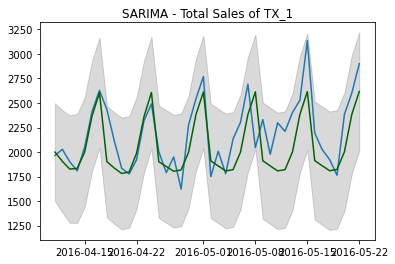

In [12]:
# Forecasting using the SARIMAX model
import matplotlib.pyplot as plt

n_periods = 42
fitted, confint = sxmodel.predict(n_periods = n_periods,  exogenous= np.tile(seasonal_index['seasonal'], 6).reshape(-1,1),  return_conf_int = True)

index_of_fc = pd.date_range(foodTest.index[0], periods = n_periods, freq = 'D')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(foodTest)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Total Sales of TX_1")
plt.show()

# Building the SARIMAX model using event_name_1 as an exogenous variable

In [13]:
# data engineering for event_name_1
CalendarDF['isweekday'] = [1 if wday >= 3 else 0 for wday in CalendarDF.wday.values]
CalendarDF['isweekend'] = [0 if wday > 2 else 1 for wday in CalendarDF.wday.values]
CalendarDF['holiday_weekend'] = [1 if (we == 1 and h not in [np.nan]) else 0 for we,h in CalendarDF[['isweekend','event_name_1']].values]
CalendarDF['holiday_weekday'] = [1 if (wd == 1 and h not in [np.nan]) else 0 for wd,h in CalendarDF[['isweekday','event_name_1']].values]

# one-hot-encoding event_name_1
CalendarDF = pd.get_dummies(CalendarDF, columns=['event_name_1'], prefix=['holiday'], dummy_na=True)

Food = CalendarDF['Food']
Food.index = CalendarDF['date']

# Section out the columns created by encoding and concat with Food dataframe
temp = CalendarDF.iloc[:,16:50]
temp.index = CalendarDF['date']
Food = pd.concat([Food, temp], axis = 1)

foodTrain = Food['20110129':'20160410']
foodTest = Food['20160411':'20160522']

In [14]:
# Build the SARIMAX model
sxmodel_event = pm.auto_arima(foodTrain[foodTrain.columns[0]], exogenous= foodTrain.iloc[:,1:],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel_event.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,7) [intercept=True]; AIC=26106.238, BIC=26322.508, Time=27.827 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=True]; AIC=27574.215, BIC=27773.849, Time=0.831 seconds
Fit ARIMA(1,0,0)x(1,1,0,7) [intercept=True]; AIC=26849.311, BIC=27060.035, Time=14.019 seconds
Fit ARIMA(0,0,1)x(0,1,1,7) [intercept=True]; AIC=26417.759, BIC=26628.484, Time=32.254 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=False]; AIC=27572.287, BIC=27766.375, Time=7.672 seconds
Fit ARIMA(1,0,1)x(0,1,0,7) [intercept=True]; AIC=27307.266, BIC=27517.990, Time=4.879 seconds
Fit ARIMA(1,0,1)x(1,1,1,7) [intercept=True]; AIC=26095.148, BIC=26316.964, Time=32.752 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Fit ARIMA(1,0,1)x(0,1,2,7) [intercept=True]; AIC=26091.495, BIC=26313.311, Time=62.138 seconds
Near non-invertible roots for order (1, 0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1899
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 7)   Log Likelihood              -13003.745
Date:                             Tue, 16 Jun 2020   AIC                          26085.490
Time:                                     01:24:56   BIC                          26301.761
Sample:                                 01-29-2011   HQIC                         26165.123
                                      - 04-10-2016                                         
Covariance Type:                               opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
intercept                       0.4918      0.344      1.430      0.153      -0.182       1.166
isweekday                       0.5532   1437.042      0.000      1.000   -2815.997    2817.104
isweekend                       0.6074   3699.768      0.000      1.000   -7250.805    7252.020
holiday_weekend               -71.0608     45.042     -1.578      0.115    -159.342      17.221
holiday_weekday               -24.3830     30.290     -0.805      0.421     -83.750      34.984
holiday_Chanukah End            0.6489    158.367      0.004      0.997    -309.744     311.042
holiday_Christmas           -1949.6729     96.083    -20.292      0.000   -2137.992   -1761.354
holiday_Cinco De Mayo         213.9189     84.099      2.544      0.011      49.089     378.749
holiday_ColumbusDay            49.0696    102.768      0.477      0.633    -152.352     250.491
holiday_Easter                398.2830    155.224      2.566      0.010      94.050     702.516
holiday_Eid al-Fitr          -239.9716     84.600     -2.837      0.005    -405.785     -74.158
holiday_EidAlAdha             101.4161    115.620      0.877      0.380    -125.194     328.026
holiday_Father's day          116.3477     96.544      1.205      0.228     -72.875     305.570
holiday_Halloween            -127.6806    134.205     -0.951      0.341    -390.717     135.356
holiday_IndependenceDay        29.6877     76.344      0.389      0.697    -119.943     179.319
holiday_LaborDay              614.0446    101.089      6.074      0.000     415.913     812.176
holiday_LentStart             102.4691     76.004      1.348      0.178     -46.495     251.433
holiday_LentWeek2              32.6654    150.632      0.217      0.828    -262.567     327.898
holiday_MartinLutherKingDay   210.9076    162.304      1.299      0.194    -107.203     529.018
holiday_MemorialDay            64.0771     79.726      0.804      0.422     -92.183     220.337
holiday_Mother's day         -201.0144     97.855     -2.054      0.040    -392.808      -9.221
holiday_NBAFinalsEnd          -15.8981     76.316     -0.208      0.835    -165.475     133.679
holiday_NBAFinalsStart         71.0922     93.883      0.757      0.449    -112.915     255.099
holiday_NewYear              -269.4607    143.152     -1.882      0.060    -550.034      11.113
holiday_OrthodoxChristmas     218.1321    175.547      1.243      0.214    -125.933     562.197
holiday_OrthodoxEaster         32.5390    135.773      0.240      0.811    -233.572     298.650
holiday_Pesach End           -120.9264    114.794     -1.053      0.292    -345.919     104.067
holiday_PresidentsDay         123.1625    128.586      0.958      0.338    -128.862     375.187
holiday_Purim End            -140.4666    100.904     -1.392      0.164    -338.235      57.302
holiday_Ramadan starts          1.1218     80.563   

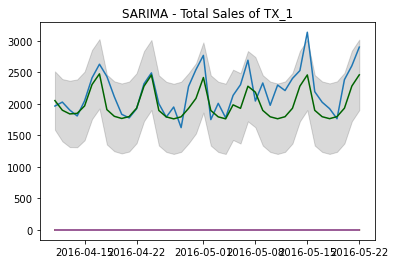

In [15]:
# Forecast
n_periods = 42
event_predict, confint = sxmodel_event.predict(n_periods = n_periods,  exogenous= foodTest.iloc[:,1:],  return_conf_int = True)

index_of_fc = pd.date_range(foodTest.index[0], periods = n_periods, freq = 'D')

# make series for plotting purpose
fitted_series = pd.Series(event_predict, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
#plt.plot(foodTrain)
plt.plot(foodTest)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Total Sales of TX_1")
plt.show()

# Comparing Results

I will now compare the forecasting results from the ARIMA model, the SARIMA model, and the two SARIMAX models using the sMAPE and MASE functions. (reference: https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9)

In [16]:
#Accuracy metrics
def symmetric_mean_absolute_percentage_error(actual,forecast):
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual)/(np.abs(actual)+np.abs(forecast)))

def mean_absolute_error(actual, forecast):
    return np.mean(np.abs(actual - forecast))

def naive_forecasting(actual, seasonality):
    return actual[:-seasonality]

def mean_absolute_scaled_error(actual, forecast, seasonality):
    return mean_absolute_error(actual, forecast) / mean_absolute_error(actual[seasonality:], naive_forecasting(actual, seasonality))

In [17]:
symmetric_mean_absolute_percentage_error(foodTest[foodTest.columns[0]], fitted) #sMAPE of SARIMAX with forced seasonality

0.09237265130478188

In [18]:
symmetric_mean_absolute_percentage_error(foodTest[foodTest.columns[0]], event_predict) #sMAPE of SARIMAX with event_name_1

0.10584339824134642

Both SARIMAX models are slightly more accurate than the ARIMA model based on sMAPE.